In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [2]:
def loadFromTxt(fname, N=None):
    if(N is not None):
        N = int(N)
        pos = np.zeros((N, 2))
        sizes = np.zeros((N, 2))
    with open(fname, "r") as f:
        first_line = float(f.readline())
        if(N is None):
            N = int(first_line)
            pos = np.zeros((N, 2))
            sizes = np.zeros((N, 2))
        N = int(first_line)
        i = 0
        for line in f.readlines():
            toks = line.split(" ")
            pos[i][0] = float(toks[0])
            pos[i][1] = float(toks[1])
            sizes[i][0] = float(toks[2])
            sizes[i][1] = float(toks[3])
            i+=1
        f.close()
    return pos, sizes, first_line

def draw_layout(pos, sizes, overlaps=None, node_color=(0,0.8,1,0.9), overlapped_color=(255/255, 51/255,51/255,0.5), ax=None, nodes_first=True, nodes_label=[], label_font_size=11,title="",figsize=(7,5),):
    def transformXY(x, y, w, h):
        newX = x - w/2
        newY = y - h/2
        return newX, newY

    if(ax is None):
        ax = plt.gca()
    if(figsize is not None):
        plt.gcf().set_size_inches(figsize)
    if(nodes_first):
        nodes_zindex = 3
    else:
        nodes_zindex = 2

    N = pos.shape[0]
    do_label_nodes = False
    if(type(nodes_label) == list and len(nodes_label) == N):
        do_label_nodes = True

    if(overlaps is None):
        overlaps = [False for _ in range(N)]

    xmin = np.inf
    xmax = -np.inf
    ymin = np.inf
    ymax = -np.inf

    for nodeid in range(N):
        (x, y) = pos[nodeid]
        (w, h) = sizes[nodeid]
        x, y = transformXY(x, y, w, h)        

        col = node_color
        if(overlaps[nodeid]):
            col = overlapped_color
        node_alpha = col[-1]
        rect = patches.Rectangle((x, y), w, h, facecolor=col, edgecolor='black', alpha=node_alpha, zorder=nodes_zindex)
        ax.add_patch(rect)
        if(do_label_nodes):
            ax.annotate(nodes_label[nodeid], (x+w/2, y+h/2), fontsize=label_font_size, color="black", va="center", ha="center")
        xmin = min(xmin, x-w)
        xmax= max(xmax, x+w)
        ymin = min(ymin, y-h)
        ymax= max(ymax, y+h)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title(title)
    ax.axis("off")
    return ax

def pairwise_overlap(pos, sizes):
    N = pos.shape[0]
    nodes_left = pos[:, 0] - sizes[:, 0]/2
    nodes_right = pos[:, 0] + sizes[:, 0]/2
    nodes_top = pos[:, 1] + sizes[:, 1]/2
    nodes_bot = pos[:, 1] - sizes[:, 1]/2

    pairwise_left = np.dstack(np.meshgrid(nodes_left, nodes_left, indexing="ij")).reshape(-1, 2)
    max_of_left = pairwise_left.max(axis=-1)
    
    pairwise_bot =  np.dstack(np.meshgrid(nodes_bot, nodes_bot, indexing="ij")).reshape(-1, 2)
    max_of_bot = pairwise_bot.max(axis=-1)
    
    pairwise_right =  np.dstack(np.meshgrid(nodes_right, nodes_right, indexing="ij")).reshape(-1, 2)
    min_of_right = pairwise_right.min(axis=-1)

    pairwise_top =  np.dstack(np.meshgrid(nodes_top, nodes_top, indexing="ij")).reshape(-1, 2)
    min_of_top = pairwise_top.min(axis=-1)

    intersections_width = np.expand_dims(min_of_right - max_of_left, 0)
    intersections_height = np.expand_dims(min_of_top - max_of_bot, 0)
    overlaps = (intersections_width > 0) * (intersections_height > 0)
    overlaps = overlaps.reshape((N,N))
    np.fill_diagonal(overlaps, 0.)
    return overlaps

In [3]:
dataset = "graphviz"
graph = "badvoro"
extension = "forbidp" # or "forbid"
isPrime_title = "" if extension== "forbid" else "'"

init_layout, init_sizes, N = loadFromTxt(f"./datasets_txt/{dataset}/{graph}.txt")
FORBID_layout, _, exec_time = loadFromTxt(f"./datasets_txt/{dataset}/{graph}.txt.{extension}", N)

init_pairwise_overlap = pairwise_overlap(init_layout, init_sizes).sum(axis=-1)
FORBID_pairwise_overlap = pairwise_overlap(FORBID_layout, init_sizes).sum(axis=-1)

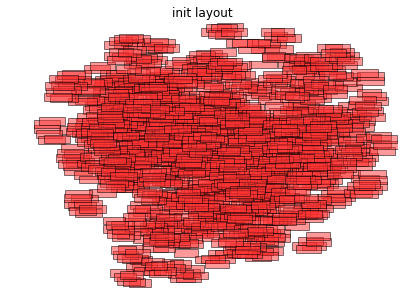

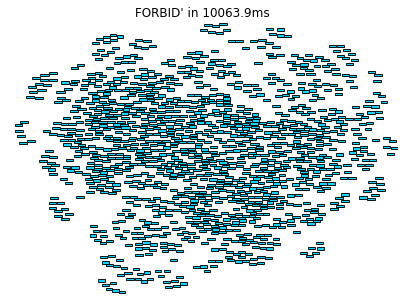

In [4]:
draw_layout(init_layout, init_sizes, overlaps=init_pairwise_overlap, title="init layout")
plt.show()
draw_layout(FORBID_layout, init_sizes, overlaps=FORBID_pairwise_overlap, title=f"FORBID{isPrime_title} in {exec_time}ms")
plt.show()